In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import pandas as pd


In [7]:
#from ordinaloss.utils.datasets import ImageFolder, create_transform_pipeline
from ordinaloss.utils.pretrained_models import classification_model_densenet, classification_model_resnet, classification_model_vgg

from ordinaloss.matan_trainers.trainers import OrdinalEngine


from ordinaloss.utils.data_utils import data_load
from ordinaloss.utils.loss_utils import SinimLoss, GirlsLoss, CSCELoss , CostSensitiveLoss
from ordinaloss.utils.loss_utils import create_ordinal_cost_matrix


import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
import torch
import numpy as np

device = "cuda:2" if torch.cuda.is_available() else "cpu"
device

loaded ordinaloss.utils.pretrained_models
loaded ordinaloss.utils.metric_utils!!
loaded ordinaloss.matan_trainers.trainers
loaded ordinaloss.utils.data_utils
loaded ordinaloss.utils.loss_utils


'cuda:2'

In [8]:
from ordinaloss.utils.callback_utils import PrintingCallback

In [9]:
os.getcwd()

'/home/dsi/marudi/projects/ordinaloss'

In [10]:
os.listdir('../datasets')

['online_shoppers',
 'kneeKL224',
 'marketing_dataset',
 'HIGGS',
 'DermMel',
 'log2.csv',
 'Pistachio',
 'Covertype',
 'secondary_data.csv']

In [11]:
# # cost_matrix = create_ordinal_cost_matrix(2, cost_distance=3, diagonal_value=20)

# from ordinaloss.matan_trainers.trainers import OrdinalEngine

# callbacks = [PrintingCallback()]

In [12]:
# model = classification_model_vgg("vgg19", num_classes = 2)
# loaders,dset_size, num_class = data_load("../datasets/DermMel/", 16,phases= ['train', 'val', 'test'],db ='Melanoma')


# cost_matrix = np.array([[1,1],
#                         [1, 1]])

# my_loss_CE = CostSensitiveLoss(weight= 10000, cost_matrix = cost_matrix, reduction = "mean")

# engine_ce = OrdinalEngine(
#     model=model, loss_fn=my_loss_CE, 
#     device=device, loaders=loaders, n_classes=2,
#     use_lr_scheduler=False,
#     optimizer_fn=SGD, lr=1.0e-3, weight_decay=5.0e-2)

In [13]:
# best_acc_train,best_acc_test,best_model,best_epoch = engine_ce.train(n_epochs=20)


In [14]:
count_majorty = len(os.listdir('../datasets/DermMel/train/0'))
count_mainor = len(os.listdir('../datasets/DermMel/train/1'))

loaders,dset_size, num_class = data_load("../datasets/DermMel/", 16,phases= ['train', 'val', 'test'],db ='Melanoma')


In [19]:
def run_experiment(lamda,device=device,loaders=loaders,n_epochs=15,baseline = False ,w_baseline=False ):
    model = classification_model_vgg("vgg19", num_classes = 2)
    
    if baseline:
        cost_matrix = np.array([[1,1],
                                [1,1]])
        
    elif w_baseline:
        cost_matrix = np.array([[lamda,lamda],
                                [1-lamda, 1-lamda]])
        
    else:
        cost_matrix = np.array([[lamda,1- lamda],
                                [1- lamda, lamda]])
        
    my_loss_curr_run = CostSensitiveLoss(weight= 10000, cost_matrix = cost_matrix, reduction = "mean")

    engine_csce = OrdinalEngine(
        model=model, loss_fn=my_loss_curr_run, 
        device=device, loaders=loaders, n_classes=2,
        use_lr_scheduler=False,
        optimizer_fn=SGD, lr=1.0e-3, weight_decay=5.0e-2)
    
    best_acc_train_exp,best_acc_test_exp,best_model_exp ,best_epoch_exp = engine_csce.train(n_epochs=n_epochs)
    
    engine_csce_best = OrdinalEngine(
        model=best_model_exp, loss_fn=my_loss_curr_run, 
        device=device, loaders=loaders, n_classes=2,
        use_lr_scheduler=False,
        optimizer_fn=SGD, lr=1.0e-3, weight_decay=5.0e-2)
    
    eval_test_csce_exp = engine_csce_best._eval_epoch(phase='test')

    return {'best_acc_train' : best_acc_train_exp,
            'best_acc_test' : best_acc_test_exp,
            'best_epoch' : best_epoch_exp , 
            'accuracy_score' : eval_test_csce_exp['accuracy'],
            'recall_score' : eval_test_csce_exp['recall_score'],
            'precision_score' : eval_test_csce_exp['precision_score'],
            'f1_score' : eval_test_csce_exp['f1_score'],
            'roc_auc_score' : eval_test_csce_exp['roc_auc_score'],
            'y_pred' : eval_test_csce_exp['y_pred'],
            'y_actual' : eval_test_csce_exp['y_actual']
            }

In [20]:
exp_range = list(np.linspace(0,1,5))
exp_range.append(count_mainor / count_majorty)

In [21]:
res ={}

In [22]:
res['ce'] = run_experiment(1,device=device,loaders=loaders,n_epochs=15,baseline = True ,w_baseline=False )

Evaluating...: 100%|██████████| 127/127 [00:06<00:00, 20.16it/s, accuracy=0.909, loss=0.244] 


In [ ]:
res['ce'] = run_experiment(1,device=device,loaders=loaders,n_epochs=15,baseline = True ,w_baseline=False )
res['wce'] = run_experiment(1,device=device,loaders=loaders,n_epochs=15,baseline = False ,w_baseline=True )

In [42]:
for i in exp_range:
    curr_res = run_experiment(i,n_epochs=15)
    res[str(i)] = curr_res

Evaluating...: 100%|██████████| 125/125 [00:10<00:00, 11.55it/s, accuracy=0.893, loss=0.274]
/home/dsi/marudi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Evaluating...: 100%|██████████| 125/125 [00:05<00:00, 21.73it/s, accuracy=0.893, loss=0.272]
/home/dsi/marudi/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Evaluating...: 100%|██████████| 127/127 [00:06<00:00, 20.44it/s, accuracy=0.904, loss=0.216] 


In [27]:
from sklearn import metrics

In [28]:
res

{'ce': {'best_acc_train': 0.9388537154281906,
  'best_acc_test': 0.9102306921061207,
  'best_epoch': 13,
  'accuracy_score': 0.9088657751657279,
  'recall_score': 0.41841004184100417,
  'precision_score': 0.6896551724137931,
  'f1_score': 0.5208333333333334,
  'roc_auc_score': 0.8943373607258708,
  'y_pred': array([[0.9986979 , 0.0013021 ],
         [0.9986777 , 0.00132225],
         [0.91435   , 0.08565006],
         ...,
         [0.10635   , 0.89365005],
         [0.15380186, 0.8461981 ],
         [0.7210872 , 0.27891275]], dtype=float32),
  'y_actual': array([0, 0, 0, ..., 1, 1, 1])}}

In [ ]:
def metric_by_ap(y_pred_proba , metric_func = metrics.accuracy_score ,n_aps = 10):
    aps = list(np.linspace(0,1,n_aps))
    y_pred_class_ap =  > ap 
    metric_func(res['ce']['y_actual'],y_pred_class_ap)

In [46]:
def metric_by_ap(y_pred_proba,y_true,metric_func,n_aps = 10):
    results = []
    for ap in list(np.linspace(0,1,n_aps)):
        y_pred_class_ap = y_pred_proba > ap 
        results.append((ap,metric_func(y_pred_class_ap,y_true)))
    return results

metric_by_ap(res['ce']['y_pred'][:,1],res['ce']['y_actual'],metrics.f1_score,n_aps=20)

[(0.0, 0.21169176262178918),
 (0.05263157894736842, 0.4722222222222222),
 (0.10526315789473684, 0.5189504373177842),
 (0.15789473684210525, 0.5475792988313857),
 (0.21052631578947367, 0.5488029465930019),
 (0.2631578947368421, 0.5562130177514794),
 (0.3157894736842105, 0.5518672199170124),
 (0.3684210526315789, 0.5398230088495575),
 (0.42105263157894735, 0.5355450236966824),
 (0.47368421052631576, 0.5241730279898219),
 (0.5263157894736842, 0.5040214477211797),
 (0.5789473684210527, 0.46368715083798884),
 (0.631578947368421, 0.4385964912280702),
 (0.6842105263157894, 0.3926380368098159),
 (0.7368421052631579, 0.34415584415584416),
 (0.7894736842105263, 0.29931972789115646),
 (0.8421052631578947, 0.18315018315018314),
 (0.894736842105263, 0.08695652173913043),
 (0.9473684210526315, 0.008333333333333333),
 (1.0, 0.0)]

In [47]:
for i in res.keys():
    print(i , res[str(i)]['accuracy_score'])

0.0 0.8994551758591405
0.25 0.9044081228330857
0.5 0.9014363546605273
0.75 0.9078751857650345
1.0 0.8984645864584471
0.1237595955813518 0.9044081228626075
ce 0.908865775136206
wce 0.9004457652598339


In [48]:
for i in res.keys():
    print(i , res[str(i)]['precision_score'])

0.0 0.6323529411764706
0.25 0.6385542168674698
0.5 0.6923076923076923
0.75 0.7523809523809524
1.0 0.6888888888888889
0.1237595955813518 0.7674418604651163
ce 0.706766917293233
wce 0.7209302325581395


In [50]:
for i in res.keys():
    print(i , res[str(i)]['recall_score'])

0.0 0.3598326359832636
0.25 0.4435146443514644
0.5 0.301255230125523
0.75 0.3305439330543933
1.0 0.2594142259414226
0.1237595955813518 0.27615062761506276
ce 0.39330543933054396
wce 0.2594142259414226


In [49]:
for i in res.keys():
    print(i , res[str(i)]['f1_score'])

0.0 0.45866666666666667
0.25 0.5234567901234568
0.5 0.4198250728862974
0.75 0.4593023255813953
1.0 0.37689969604863227
0.1237595955813518 0.40615384615384614
ce 0.5053763440860215
wce 0.38153846153846155


In [51]:
for i in res.keys():
    print(i , res[str(i)]['roc_auc_score'])

0.0 0.8851135348596681
0.25 0.8968783790136806
0.5 0.8961214799492268
0.75 0.8936791876263457
1.0 0.8855013868647453
0.1237595955813518 0.8918292510930375
ce 0.8946029805838935
wce 0.890289596163791


In [92]:
model = classification_model_vgg("vgg19", num_classes = 2)
loaders,dset_size, num_class = data_load("../datasets/DermMel/", 16,phases= ['train', 'val', 'test'],db ='Melanoma')


# cost_matrix = np.array([[0.3,0.4],
#                         [1, 0]])

cost_matrix = np.array([[0.1,0.9],
                        [0.9, 0.1]])

my_loss_csce = CostSensitiveLoss(weight= 10000, cost_matrix = cost_matrix, reduction = "mean")

engine_csce = OrdinalEngine(
    model=model, loss_fn=my_loss_CE, 
    device=device, loaders=loaders, n_classes=2,
    use_lr_scheduler=False,
    optimizer_fn=SGD, lr=1.0e-3, weight_decay=5.0e-2)

In [93]:
best_acc_train2,best_acc_test2,best_model2 ,best_epoch2 = engine_csce.train(n_epochs=15)

Evaluating...: 100%|██████████| 125/125 [00:05<00:00, 22.37it/s, accuracy=0.907, loss=0.251] 


In [94]:
engine_csce_best = OrdinalEngine(
    model=best_model2, loss_fn=my_loss_CE, 
    device=device, loaders=loaders, n_classes=2,
    use_lr_scheduler=False,
    optimizer_fn=SGD, lr=1.0e-3, weight_decay=5.0e-2)

eval_test_csce = engine_csce_best._eval_epoch(phase='test')
print('best_epoch',best_epoch2)

print('best_acc_test',eval_test_csce['accuracy'])
print('best_acc_train: ',best_acc_train2,' best_acc_val: ',best_acc_test2)

print('recall_score',eval_test_csce['recall_score'])
print('precision_score',eval_test_csce['precision_score'])
print('f1_score',eval_test_csce['f1_score'])


Evaluating...: 100%|██████████| 127/127 [00:05<00:00, 22.32it/s, accuracy=0.906, loss=0.258] 

best_epoch 11
best_acc_test 0.9063893016639943
best_acc_train:  0.9440186604465178  best_acc_val:  0.9107321966196613
recall_score 0.3263598326359833
precision_score 0.7358490566037735
f1_score 0.45217391304347826


In [95]:
eval_test_csce['bin_counter']

tensor([0.9475, 0.0525], device='cuda:2')

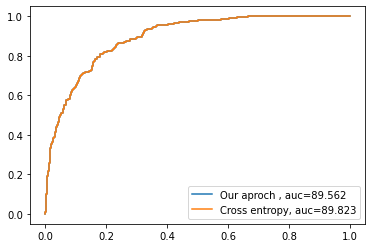

In [99]:
from sklearn import metrics
y_test = eval_test_csce['y_actual']
y_pred_proba= eval_test_csce['y_pred'][:,1]
fpr, tpr, _ = metrics.roc_curve(eval_test['y_actual'],  eval_test['y_pred'][:,1])
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Our aproch , auc="+str(round(auc,5)*100))
plt.plot(fpr2,tpr2,label="Cross entropy, auc="+str(round(auc2,5)*100))

plt.legend(loc=4)
plt.show()

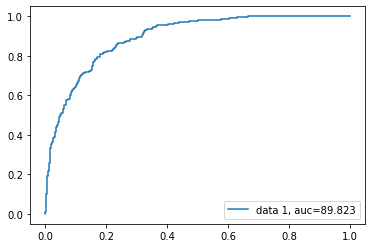

In [97]:
from sklearn import metrics
y_test = eval_test_ce['y_actual']
y_pred_proba= eval_test_ce['y_pred'][:,1]
fpr2, tpr2, _ = metrics.roc_curve(eval_test['y_actual'],  eval_test['y_pred'][:,1])
auc2 = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr2,tpr2,label="data 1, auc="+str(round(auc2,5)*100))
plt.legend(loc=4)
plt.show()

In [76]:
engine_ce_best = OrdinalEngine(
    model=best_model, loss_fn=my_loss_CE, 
    device=device, loaders=loaders, n_classes=2,
    use_lr_scheduler=False,
    optimizer_fn=SGD, lr=1.0e-3, weight_decay=5.0e-2)

eval_test_ce = engine_ce_best._eval_epoch(phase='test')
print('best_acc_test',eval_test_ce['accuracy'])
print('best_acc_train: ',best_acc_train,' best_acc_val: ',best_acc_test)

print('recall_score',eval_test_ce['recall_score'])
print('precision_score',eval_test_ce['precision_score'])
print('f1_score',eval_test_ce['f1_score'])
eval_test_ce

Evaluating...: 100%|██████████| 127/127 [00:05<00:00, 22.01it/s, accuracy=0.904, loss=0.244] 

best_acc_test 0.9044081228626075
best_acc_train:  0.949516827724092  best_acc_val:  0.9112337011033099
recall_score 0.4476987447698745
precision_score 0.6369047619047619
f1_score 0.5257985257985257


{'bin_counter': tensor([0.9168, 0.0832], device='cuda:2'),
 'loss': 0.24396336339174254,
 'accuracy': 0.9044081228626075,
 'recall_score': 0.4476987447698745,
 'precision_score': 0.6369047619047619,
 'f1_score': 0.5257985257985257,
 'y_pred': array([[0.9988194 , 0.00118058],
        [0.99896085, 0.00103913],
        [0.88207555, 0.11792448],
        ...,
        [0.07193402, 0.92806596],
        [0.14865422, 0.8513458 ],
        [0.5188726 , 0.4811274 ]], dtype=float32),
 'y_actual': array([0, 0, 0, ..., 1, 1, 1]),
 'score_dist': 0    1851
 1     168
 dtype: int64}

In [48]:
# model = classification_model_vgg("vgg19", num_classes = 1)
# loaders,dset_size, num_class = data_load("../projects/datasets/DermMel/", 16,phases= ['train', 'val', 'test'],db ='Melanoma')


# cost_matrix = np.array([[1,1],
#                         [1, 1]])

# my_loss_CE = CostSensitiveLoss(weight= 10000, cost_matrix = cost_matrix, reduction = "mean")

# engine_ce = model_engine.OrdinalEngine(
#     model=model, loss_fn=my_loss_CE, 
#     device=device, loaders=loaders, n_classes=1,
#     use_lr_scheduler=False,
#     optimizer_fn=SGD, lr=1.0e-3, weight_decay=5.0e-2)aaa

In [ ]:
model = classification_model_vgg("vgg19", num_classes = 1)
loaders,dset_size, num_class = data_load("../projects/datasets/DermMel/", 16,phases= ['train', 'val', 'test'],db ='Melanoma')


cost_matrix = np.array([[1,1],
                        [1, 1]])

my_loss_CE = CostSensitiveLoss(weight= 10000, cost_matrix = cost_matrix, reduction = "mean")

engine_ce = model_engine.OrdinalEngine(
    model=model, loss_fn=my_loss_CE, 
    device=device, loaders=loaders, n_classes=1,
    use_lr_scheduler=False,
    optimizer_fn=SGD, lr=1.0e-3, weight_decay=5.0e-2)

In [42]:
X, y = next(iter(loaders["train"]))
X, y = X.to(device), y.to(device)

y_pred = model(X)


In [43]:
engine._train_epoch()

Training, epoch 0: 100%|██████████| 376/376 [00:44<00:00,  8.38it/s, accuracy=0.88, loss=0.317, mae=0.12]  


In [24]:
class PredictionsCollector:
    def __init__(self, n_classes, device):
        self.device = device
        self.predictions_collector = []
        self.actual_collector = []
        
    @torch.no_grad()
    def update(self, y_pred:torch.Tensor, y_true: torch.Tensor):
        '''
        y_pred is NxC (even if C is 2)
        y_true is N (actual classes [1,2,3,0,2...])
        
        '''
        self.predictions_collector.append(y_pred.cpu().numpy())
        self.actual_collector.append(y_true.cpu().numpy())
        
    def finalize(self):
        self.predictions_collector = np.concatenate(self.predictions_collector) #should be numpy
        self.actual_collector = np.concatenate(self.actual_collector)

pc = PredictionsCollector(3, 0)
y_true = torch.tensor([1,2,0], device = 0)
y_pred = torch.tensor([[0,1,0], [0,0,1], [1,0,0]], device = 0)

pc.update(y_pred, y_true)

pc.update(y_pred, y_true)
pc.finalize()

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0]])

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0]])